In [1]:
using DataFrames
using Gadfly
using Chemfiles
set_default_plot_size(30cm, 12cm)
home = "/home/german/labo/18/lbp/run"
rtdos = "/home/german/labo/18/lbp/rtdos_log"

"/home/german/labo/18/lbp/rtdos_log"

In [2]:
# Agarra una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3x3N. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas de carbonos alfa
function format_pca_aa(in_mtx::Array{Float64, 2})
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]

    aa = Int64
    try
        aa = convert(Int64, v_length / 3)
    catch
        error("Vector length: ", v_length, " is not divisible by 3.")
    end

    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    for j = 1:v_nbr
        list_out_mtx[j] = reshape(in_mtx[:, j], 3, aa)
    end

    return list_out_mtx
end


# Agarra la topología una matriz de PCA en Calpha de 3Nx3N-6 y devuelve
# una lista de 3N-6 matrices, c/u de 3xNatomos. C/ mtx es 1 modo reordenado
# p/ matchear las matrices de coordenadas del pdb q dió lugar a la topología.

# También devuelve un array con el nro de atomos q tiene c/ aa
function format_pca_atom(in_top::Topology, in_mtx::Array{Float64, 2}, mask::Array{Float64, 1} = 0)
    # Preparo variables
    aa = Int64
    aa_3 = Int64
    if mask == 0 
        aa = convert(Int64, count_residues(in_top))
    else
        aa = length(mask)
    end
    aa_3 = aa * 3
    
    v_length = size(in_mtx)[1]
    v_nbr = size(in_mtx)[2]
    if v_length != aa_3
        error("Input vector with wrong dimensions: ", v_length, "  ", (aa_3, 1))
    end

    # Determino orden de residuos (hay q actualizar el Julia Chemfiles)
    tmp = Array{Int64}(aa)
    ids = Array{Int64}(aa)
    [ ids[i+1] = convert(Int64, id((Residue(in_top, i)))) for i = 0:aa-1 ]
    idx = sortperm(ids)
    # Determino el nro de atomos de c/ aminoácido. Resto 1 pq Chemfiles tiene 0-indexing
    [ tmp[i] = size(Residue(in_top, mask[i] - 1)) for i = 1:aa ]
    natom_aa = tmp[idx]
    natoms = sum(natom_aa)

    # Adapto el vector p/ darle la misma forma q la matriz de coordenadas
    list_out_mtx = Array{Array{Float64, 2}, 1}(v_nbr);
    
    for j in 1:v_nbr
        vector = reshape(in_mtx[:, j], 3, aa)
        list_out_mtx[j] = Array{Float64}(3, natoms)
        cursor = 0
        for i = 1:aa
            rango = Array{Int64}(natom_aa[i])
            if i == 1
                list_out_mtx[j][:, 1:natom_aa[i]] = repmat(vector[:, i], 1, natom_aa[i])
                cursor = natom_aa[i]
                continue
            end
            rango = collect(cursor+1:cursor + natom_aa[i])
            list_out_mtx[j][:, rango] = repmat(vector[:, i], 1, natom_aa[i])
            cursor += natom_aa[i]
        end
    end

    return list_out_mtx, natom_aa
end

format_pca_atom (generic function with 2 methods)

In [3]:
function get_κ(in_vec::Array{Float64, 1})
    not_null = copy(in_vec)
    not_null[not_null .== 0] = 0.000001
    const κ = (exp.(-mapslices(x -> sum(x), mapslices(x->x.^2 .* log.(x.^2), not_null, 1), 1))
        / length(not_null))[1]
    return κ
end

function get_pnum(in_vec::Array{Float64, 1})
    nor_vec = in_vec ./ norm(in_vec) 
    return convert(Int64, round(sum(nor_vec .^ 4) .^ -1))
end

function tognm(vtor_anm)
    vtor_gnm = Array{Float64}
    try
        vtor_gnm = Array{Float64}(convert(Int64, length(vtor_anm)/3));
    catch e
        warn("Input vector's length is not a 3 multiplier")
        error(e)
    end
    vtor_anm =  vtor_anm.^2
    for i=1:convert(Int64, length(vtor_anm)/3)
        vtor_gnm[i] = sqrt(vtor_anm[i*3-2] + vtor_anm[i*3-1] + vtor_anm[i*3])
    end
    return vtor_gnm
end

function WeightedHist(in_vec, in_bins, in_weight, density = false, include_bounds = true)
    # Safety check    
    if length(in_vec) != length(in_weight)
        error("Each element of the input vector needs one weight")
        return
    end
    
    # Prepare variables
    out_counts = Array{Float64}(length(in_bins)-1)
    
    # Get weighted histogram
    if include_bounds
        for i=1:length(in_bins)-1
            if i == 1
                # Include those that fall before the beggining of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .<= in_bins[i])
                out_counts[i] = sum(in_weight[temp_bool])
            elseif i == length(in_bins)-1
                # Include those that fall after the end of the bins
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1]) .| (in_vec .>= in_bins[end])
                out_counts[i] = sum(in_weight[temp_bool])
            else
                temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
                out_counts[i] = sum(in_weight[temp_bool])
            end
        end
    else
        for i=1:length(in_bins)-1
            temp_bool = (in_vec .>= in_bins[i]) .& (in_vec .< in_bins[i+1])
            out_counts[i] = sum(in_weight[temp_bool])
        end
    end
    
    
    # Get bins middle points
    out_middle = (in_bins[1:end-1] + in_bins[2:end]) / 2
    
    # Turn counts into density
    if (density == true)
        out_counts = out_counts ./ sum(out_counts) 
    end
    return out_counts, out_middle
end

function MatHisInd2D(in_vec_x::AbstractArray, in_vec_y::AbstractArray,
    in_bins_x::AbstractArray, in_bins_y::AbstractArray,
    include_bounds = true)

    const cnt = length(in_vec_x)
    if  length(in_vec_y) != cnt
        error("Input vectors length don't match. X: ", in_vec_x, " Y: ", in_vec_y)
    end
         
    const n_x = length(in_bins_x)
    const n_y = length(in_bins_y)
    
    his_ind = [Int[] for i=1:n_x, j=1:n_y]
    his = zeros(Int64, n_x, n_y)
    if include_bounds
        for i in 1:cnt
            x = searchsortedfirst(in_bins_x, in_vec_x[i])
            y = searchsortedfirst(in_bins_y, in_vec_y[i])
            if x > n_x
                x = n_x
            end
            if y > n_y
                y = n_y
            end
            
            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    else
        for i in 1:cnt
            const x = searchsortedfirst(in_bins_x, in_vec_x[i])
            const y = searchsortedfirst(in_bins_y, in_vec_y[i])
        
            if x > n_x || y > n_y
                continue
            end
            if (x == 1 && isless(x, in_vec_x[x])) || (y == 1 && isless(y, in_vec_y[y]))
                continue
            end

            push!(his_ind[x, y], i)
            his[x, y] += 1
        end
    end
    
    return his_ind, his
end

function read_ptraj_modes(filename, nmodes::Int64=0, norma::Bool=true)
    modes_text = readdlm(filename, skipstart=0, skipblanks=true, comments=true,
        comment_char='\*')

    if nmodes == 0
        nmodes = modes_text[1, 5]
    end
    modes_elements = modes_text[2, 1]

    ncoords = convert(Int64, modes_elements)
    lines = ceil(Int64, ncoords/7)
    rest = convert(Int64, ncoords % 7)

    eval = Array{Float64}(nmodes);
    mode = Array{Float64}(ncoords, nmodes);
    temp1 = Array{Float64}(ncoords, 1);
    temp2 = Array{Float64}(ncoords+(7-rest));

    j=lines + 1 + 2 # 1 p/ q lea la prox linea 2 por el header
    for i=1:nmodes
        eval[i] = modes_text[j, 2]
        temp = permutedims(modes_text[(j+1):(lines+j), :], [2, 1])
        temp2 = reshape(temp, ncoords+(7-rest))
        for k=(rest+1):7
            pop!(temp2)
        end
        mode[:, i] = temp2
        j = j + lines + 1
    end

    if norma == true
        for i=1:nmodes
            mode[: ,i] = mode[:, i] / norm(mode[:, i])
        end
    end

    return mode, eval
end

function energia_gdte(evals::Array{Float64, 1}, gdte::Array{Float64, 1}, d::Float64 = 1.)

    if length(evals) != length(gdte)
        error("Lengths of evals and gdte don't match. Aborting.") 
    end
    
    # Declaro cte de boltzmann, avogadro, y temperatura.
    const k = 1.38064852e-23
    const avgdro = 6.0221409e+23
    const T = 298
    const RT =  k * avgdro * T * 1E-3 * 0.239006 # Kcal/mol
    const cte = 11792.08316093831
    
    return d^2 * 0.5 * RT * sum(evals.^2 .* gdte.^2) / cte # Kcal/mol
end

energia_gdte (generic function with 2 methods)

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [21]:
pdb = "4uet"
# Leo modos
modes_4uet, evals_4uet = read_ptraj_modes(joinpath(home, pdb,  "pca", string("full_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_4uet))
aa = convert(Int64,aa3 / 3)

# Leo volúmenes originales
vol_avg_4uet = convert(Float64, readdlm(joinpath(home, pdb,  "ndd", string("vol_avg_", pdb)))[3])

# Leo volúmenes NDD
ndd_out_4uet = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb,  "ndd", string("out_ndd_", pdb)))[2:end, 2])

# VGV
vgv_4uet = eval(:(ndd_out_4uet .- vol_avg_4uet))
vgv_4uet = vgv_4uet ./ norm(vgv_4uet);

### Obtiene los aa's del hueco

In [5]:
# VGV cartesiano
xyz_vgv_4uet = tognm(modes_4uet * vgv_4uet)

# Pnumber aminoácidos según VGV (aminoácidos de la pared)
cut_4uet = get_pnum(xyz_vgv_4uet)

# Índices de pnumber aminoácidos
idx_cut_4uet = sort(sortperm(abs.(xyz_vgv_4uet), rev = true)[1:cut_4uet])

# Índices de pnumber aminoácidos en 3aa coordenadas
idx_cut_4uet_3 = Array{Int64}(length(idx_cut_4uet) * 3)
for i = 1:length(idx_cut_4uet)
    idx_cut_4uet_3[3*i-2] = idx_cut_4uet[i] * 3 - 2
    idx_cut_4uet_3[3*i-1] = idx_cut_4uet[i] * 3 - 1
    idx_cut_4uet_3[3*i] = idx_cut_4uet[i] * 3
end

### Obtiene los pnum modos y pnum eigenvals. Cut y enteros

In [6]:
# Pnumber de VGV
vgv_pnu_4uet = get_pnum(vgv_4uet)

# Pnumber indices
idx_vgv_pnu_4uet = sortperm(abs.(vgv_4uet), rev=true)[1:vgv_pnu_4uet]

# Pnumber modes
modes_pnu_4uet = modes_4uet[:, idx_vgv_pnu_4uet]

# Pnumber eigenvalues
evals_pnu_4uet = evals_4uet[idx_vgv_pnu_4uet];

# Todos los modos recortados según pnumber aminoácidos y normalizo
modes_cut_4uet = modes_4uet[idx_cut_4uet_3, :]
modes_cut_4uet = mapslices(x -> x ./ norm(x), modes_cut_4uet, 1)

# Pnum modos recortados según pnumber aminoácidos y normalizo
modes_pnu_cut_4uet = modes_pnu_4uet[idx_cut_4uet_3, :]
modes_pnu_cut_4uet = mapslices(x -> x ./ norm(x), modes_pnu_cut_4uet, 1);

### κ

In [7]:
# Colectividad de modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_4uet, 1), 1)))
κ_modes_4uet = reshape(tmp, length(tmp))

# Colectividad de pnum modos enteros
tmp = eval(:(mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_4uet, 1), 1)))
κ_modes_pnu_4uet  = reshape(tmp, length(tmp))

# Colectividad de modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_cut_4uet, 1), 1)
κ_modes_cut_4uet  = reshape(tmp, length(tmp))

# Colectividad de pnum modos recortados
tmp = mapslices(x -> get_κ(x), mapslices(x -> tognm(x), modes_pnu_cut_4uet, 1), 1)
κ_modes_pnu_cut_4uet = reshape(tmp, length(tmp));

### Pnumber

In [8]:
# Pnumber de modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_4uet, 1), 1)
col_modes_4uet = reshape(tmp, length(tmp)) ./ aa

# Pnumber de pnum modos enteros
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_4uet, 1), 1)
col_modes_pnu_4uet = reshape(tmp, length(tmp)) ./ aa

# Pnumber de modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_cut_4uet, 1), 1)
col_modes_cut_4uet = reshape(tmp, length(tmp))  ./ cut_4uet

# Pnumber de pnum modos cut
tmp = mapslices(x -> get_pnum(x), mapslices(x -> tognm(x), modes_pnu_cut_4uet, 1), 1)
col_modes_pnu_cut_4uet = reshape(tmp, length(tmp))  ./ cut_4uet;

# Frecuencia

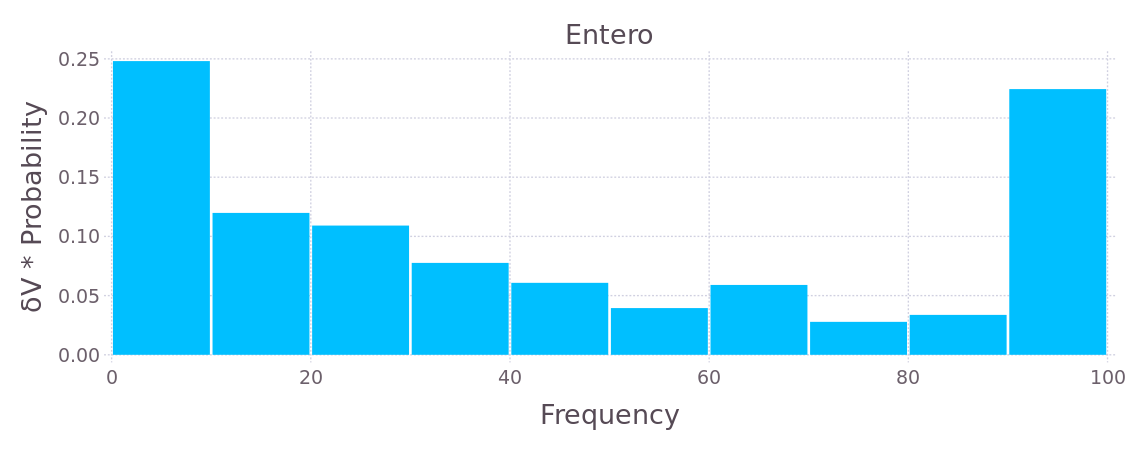

In [20]:
# Los bins van de 0 a la fqcia más alta + 10%
top_evals = maximum(evals_4uet)
bins_evals = collect(0:10:100)

# Histograma ponderado
Whis_evals_4uet, Wbins_evals_4uet = WeightedHist(evals_4uet, bins_evals, abs.(vgv_4uet), true);
df_Whis_evals_4uet = DataFrame(Probability = Whis_evals_4uet, Frequency = Wbins_evals_4uet);


pdf_Whis_evals_4uet = plot(df_Whis_evals_4uet, x="Frequency", y="Probability", Geom.bar,
    Guide.title("Entero"),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
    Guide.xticks(ticks=collect(0:20:100)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Colectividad

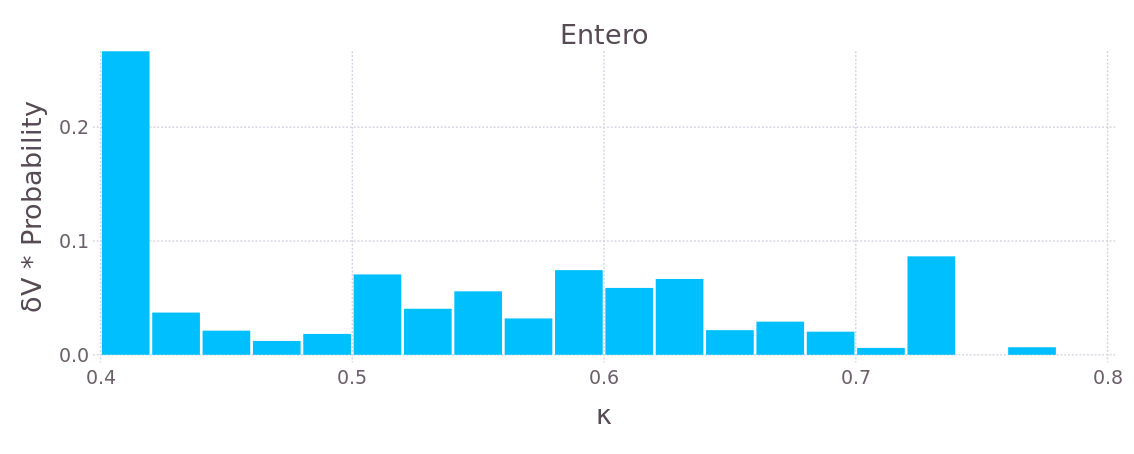

In [10]:
# Los bins van de 0 a la fqcia más alta + 10%
top_κ = maximum(κ_modes_4uet)
bins_κ = collect(0.4:.02:.8)

# Histograma ponderado
Whis_κ_4uet, Wbins_κ_4uet = WeightedHist(κ_modes_4uet, bins_κ, abs.(vgv_4uet), true);
df_Whis_κ_4uet = DataFrame(Probability = Whis_κ_4uet, κ = Wbins_κ_4uet);

pdf_Whis_κ_4uet = plot(df_Whis_κ_4uet, x="κ", y="Probability", Geom.bar,
    Guide.title("Entero"),
    Coord.cartesian(ymax = 0.26),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

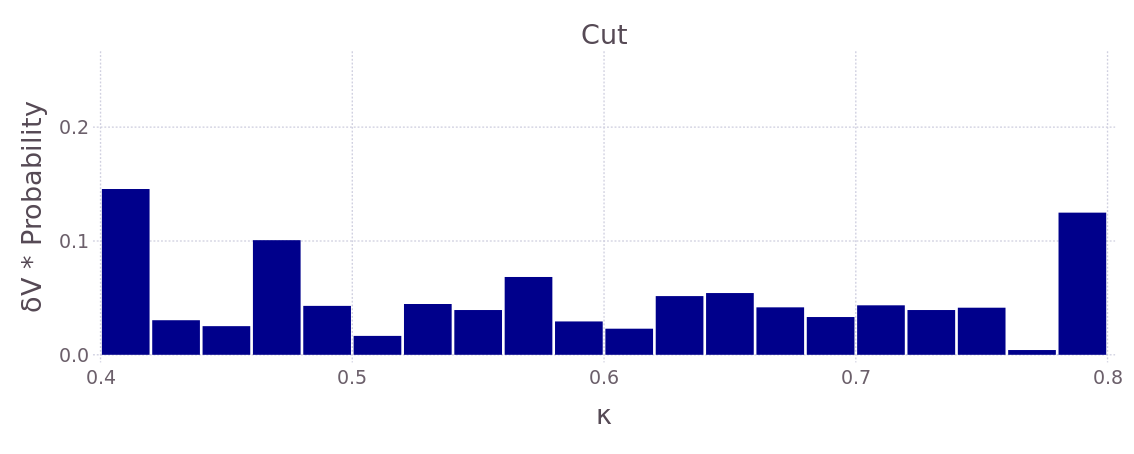

In [11]:
# Uso los bins del anterior
# Histograma ponderado
Whis_κ_cut_4uet, Wbins_κ_cut_4uet = WeightedHist(κ_modes_cut_4uet, bins_κ, abs.(vgv_4uet), true);
df_Whis_κ_cut_4uet = DataFrame(Probability = Whis_κ_cut_4uet, κ = Wbins_κ_cut_4uet);

pdf_Whis_κ_cut_4uet = plot(df_Whis_κ_cut_4uet, x="κ", y="Probability", Geom.bar,
    Guide.title("Cut"),
    Coord.cartesian(ymax = 0.26),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# Colectividad en pnumber

### Modos enteros

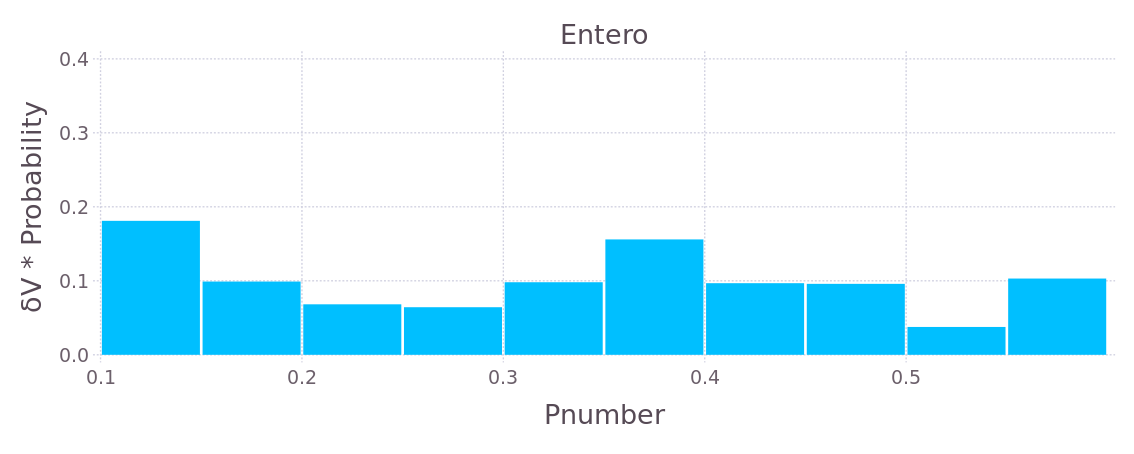

In [12]:
# Los bins van de 0 a la fqcia más alta + 10%
top_col = maximum(col_modes_4uet)
bins_col = collect(0.1:.05:.6)

# Histograma ponderado
Whis_col_4uet, Wbins_col_4uet = WeightedHist(col_modes_4uet, bins_col, abs.(vgv_4uet), true);
df_Whis_col_4uet = DataFrame(Probability = Whis_col_4uet, Pnumber = Wbins_col_4uet);

pdf_Whis_col_4uet = plot(df_Whis_col_4uet, x="Pnumber", y="Probability", Geom.bar,
    Guide.title("Entero"),
    Coord.cartesian(xmin = 0.1, ymax = 0.4),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"),
    # Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

### Modos recortados

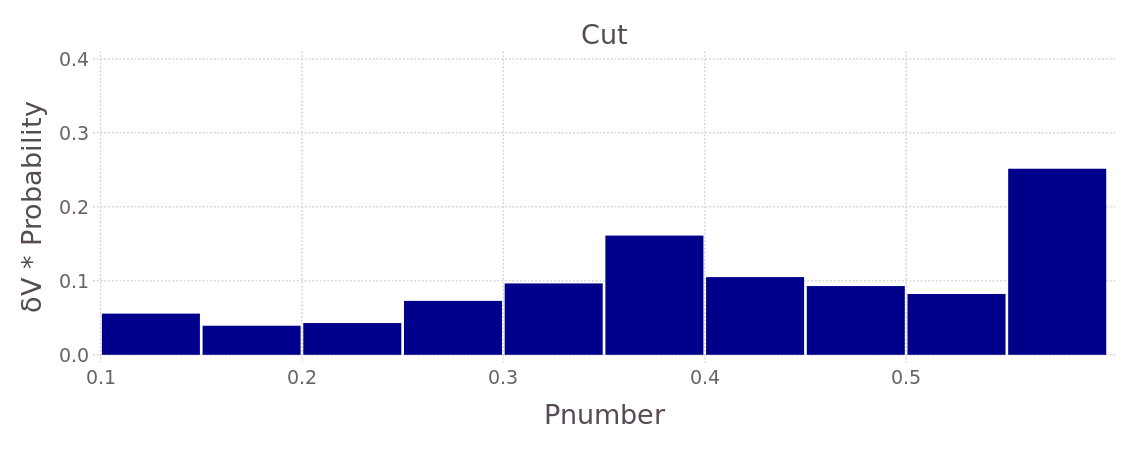

In [13]:
# Uso los bins de arriba
# Histograma ponderado
    Whis_col_cut_4uet, Wbins_col_cut_4uet = WeightedHist(col_modes_cut_4uet, bins_col, abs.(vgv_4uet), true);
df_Whis_col_cut_4uet = DataFrame(Probability = Whis_col_cut_4uet, Pnumber = Wbins_col_cut_4uet);

pdf_Whis_col_cut_4uet = plot(df_Whis_col_cut_4uet, x="Pnumber", y="Probability", Geom.bar,
    Guide.title("Cut"),
    Coord.cartesian(xmin = 0.1, ymax = 0.4),
    # Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    Guide.ylabel("δV * Probability", orientation=:vertical),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

# AAs de la pared

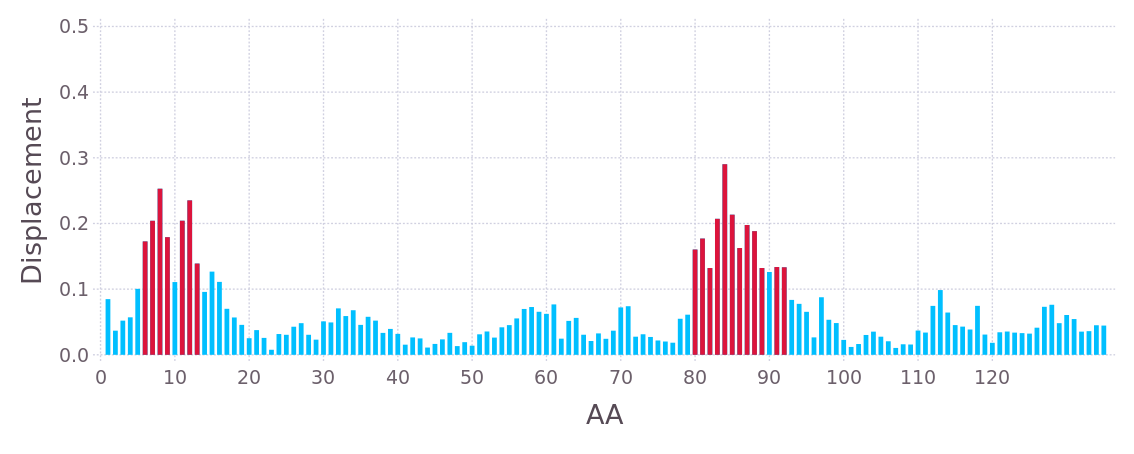

In [14]:
tmp = abs.(xyz_vgv_4uet)
tmp_ = copy(tmp)
tmp_[tmp_ .< .13] .= 0.

layer_temp_1 = layer(DataFrame(Displacement = tmp), Geom.bar, y = "Displacement")
layer_temp_2 = layer(DataFrame(Displacement = tmp_), Geom.bar, y = "Displacement",
Theme(default_color=colorant"crimson", bar_spacing=2pt))


pdf_cart_gdte = plot(layer_temp_2, layer_temp_1,
    Guide.xlabel("AA"),
    Guide.ylabel("Displacement"), Coord.cartesian(ymax = 0.5),
    Guide.xticks(ticks=collect(0:10:120)),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt,
        key_label_font_size = 15pt))

## Volumen de la trayectoria

In [43]:
trj_vol = convert(Array{Float64, 1}, readdlm(joinpath(home, pdb, "cavidad", string("vol_trj_", pdb)))[:, 3]);
df_trj_vol = DataFrame(Volume = trj_vol, Time = collect(1:length(trj_vol)));

bin_vol = collect(100:20:1700)
wgh_vol = fill(1.0, length(trj_vol))

# Histograma ponderado
Whis_vol_4uet, Wbins_vol_4uet = WeightedHist(trj_vol, bin_vol, wgh_vol, true, true);
df_Whis_vol_4uet = DataFrame(Probability = Whis_vol_4uet, Volume = Wbins_vol_4uet);

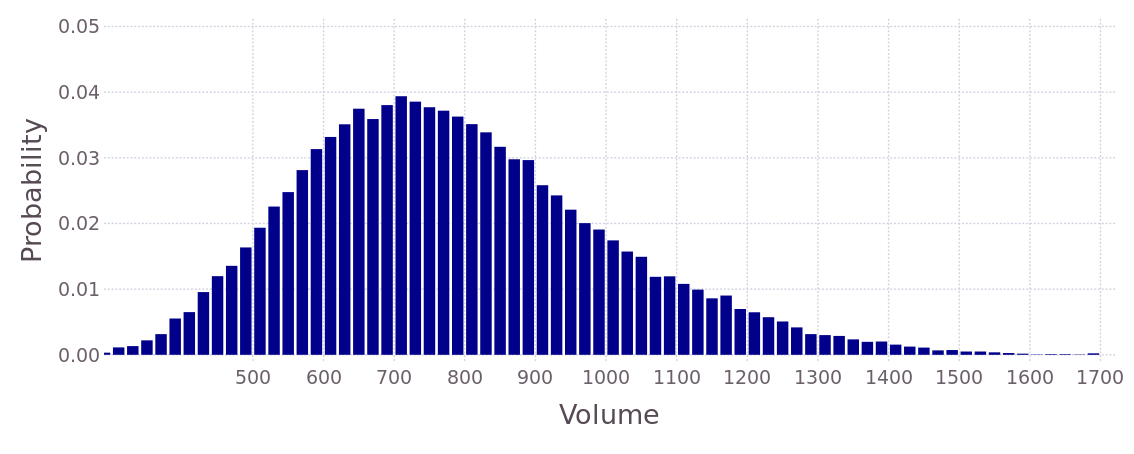

In [44]:
pdf_Whis_vol = plot(df_Whis_vol_4uet, x = "Volume", y = "Probability", Geom.bar,
    #Guide.title("Cut"),
    Coord.cartesian(xmin = 300, xmax = 1710, ymax = 0.05),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.xticks(ticks = collect(500:100:1700)),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

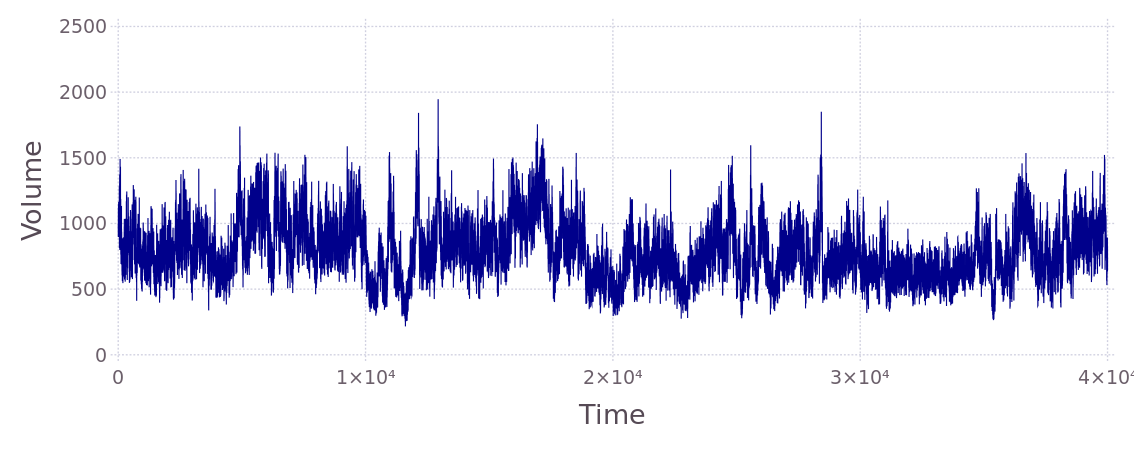

In [45]:
pdf_trj_vol = plot(df_trj_vol, x = "Time", y = "Volume",
    Geom.line,
    #Geom.smooth(method=:loess,smoothing=0.001),
    #Guide.title("Cut"),

    Coord.cartesian(ymin = 0, ymax = 2500),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"DarkBlue"),
        minor_label_font_size = 14pt, major_label_font_size = 20pt, key_title_font_size = 20pt))

In [46]:
[ mean(trj_vol) ; std(trj_vol) ]

2-element Array{Float64,1}:
 786.991
 216.211

# Energía

In [47]:
points = 21
maxi = floor(points / 2)
mini = -maxi
RT = 0.693

E_4uet = Array{Float64,1}(points)
i = 0
for d = mini:maxi
    i+=1
    E_4uet[i] = energia_gdte(evals_4uet, vgv_4uet, d * 5E-1)
end

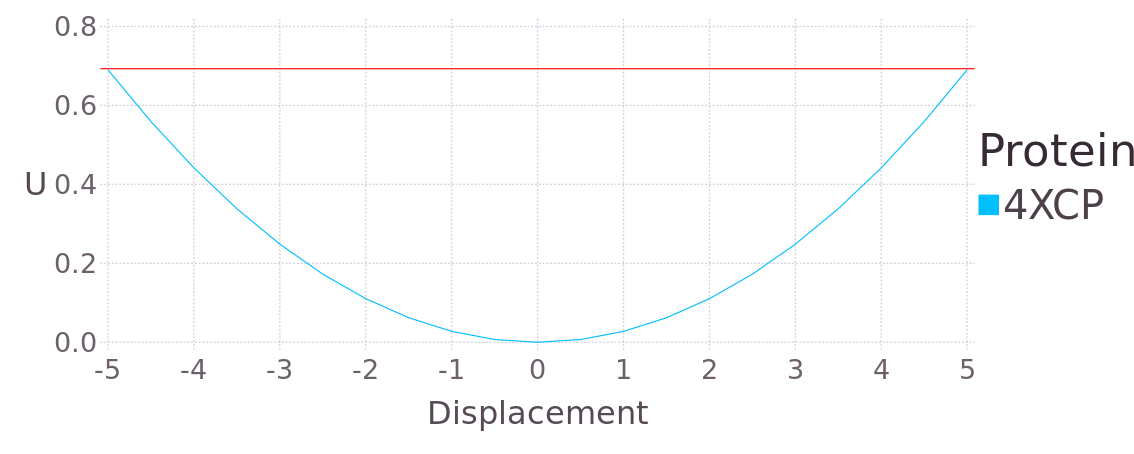

In [48]:
# Compilo en un dataframe.
df_E = DataFrame(U = E_4uet,
    Displacement = repeat(collect(mini:1:maxi) * 5E-1, outer = [1]), 
    Protein = fill("4XCP", points))

pdf_E = plot(df_E, y = "U", x = "Displacement", color = "Protein", Geom.line,
    yintercept = [RT], Geom.hline(color = "red"),
    Guide.xticks(ticks = collect(mini:2:maxi) * 5e-1),
    Theme(bar_spacing=2pt, grid_line_width=1pt, Theme(default_color=colorant"deepskyblue"),
        minor_label_font_size = 20pt, major_label_font_size = 24pt, key_title_font_size = 34pt,
        key_label_font_size = 30pt))

# PCA projección

#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

In [53]:
#
# Get avg ready
#
mask = collect(10:144);
in_avg_trj = Trajectory(joinpath(home, pdb, "pca", string("full_avg_", pdb, ".pdb")))
in_avg_frm = read(in_avg_trj)
in_avg_top = Topology(in_avg_frm)
orig_aa = convert(Int64, count_residues(in_avg_top))

# Get indices de CA
orig_cas_idx = Array{Int64, 1}(orig_aa)
k = 0
for i = 0:convert(Int64, size(in_avg_top)-1)
    if name(Atom(in_avg_frm, i)) == "CA"
        k+=1
        orig_cas_idx[k] = i + 1
    end
end
cas_idx = orig_cas_idx[mask]
aa = length(cas_idx)
aa_3 = aa * 3
# Estas son las coordenadas q voy a usar p/ restar
avg_xyz = positions(in_avg_frm)[:, cas_idx];

# Preparo
in_trj = Trajectory(joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")))
nframes = convert(Int64, nsteps(in_trj))
close(in_trj)
diff_4uet = Array{Float64, 2}(aa_3, nframes)
vec_nframes = convert(Array{Int64}, collect(0:nframes/10:nframes));

# Ahora obtengo las proyecciones
for j = 1:length(vec_nframes)-1
    in_trj = Trajectory(joinpath(home, pdb, "pca", string("full_avgfit_", pdb, ".nc")))
    for i = vec_nframes[j]:vec_nframes[j+1]-1
        diff_4uet[:, i+1] = reshape(positions(read_step(in_trj, i))[:, cas_idx] .- avg_xyz, aa_3)
    end
    close(in_trj)
    println(j)
    gc()
end
writedlm(joinpath(rtdos, "diff_4uet"), diff_4uet)

LoadError: [91mInterruptException:[39m

In [52]:
gc()

#### Leo los vectores diferencia y los normalizo

#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [36]:
diff_4uet = readdlm(joinpath(rtdos, "diff_4uet"))
nframes = size(diff_4uet)[2]
norm_diff_4uet = mapslices(x -> x ./ norm(x), diff_4uet, 1);

prj_1_4uet = Array{Float64, 1}(nframes)
prj_2_4uet = Array{Float64, 1}(nframes)

for i = 1:nframes
    prj_1_4uet[i] = dot(norm_diff_4uet[:, i], modes_4uet[:, 1])
    prj_2_4uet[i] = dot(norm_diff_4uet[:, i], modes_4uet[:, 2])
end

df_prj_4uet = DataFrame(PCA1 = prj_1_4uet, PCA2 = prj_2_4uet,
    Time = collect(1:length(prj_1_4uet)));

# Smooth
smooth_prj_1_4uet = [ mean(prj_1_4uet[i:i+10]) for i = 1:10:length(prj_1_4uet)-10 ]
smooth_prj_2_4uet = [ mean(prj_2_4uet[i:i+10]) for i = 1:10:length(prj_2_4uet)-10 ];

df_smooth_prj_4uet = DataFrame(PCA1 = smooth_prj_1_4uet, PCA2 = smooth_prj_2_4uet,
    Time = collect(1:length(smooth_prj_1_4uet)));

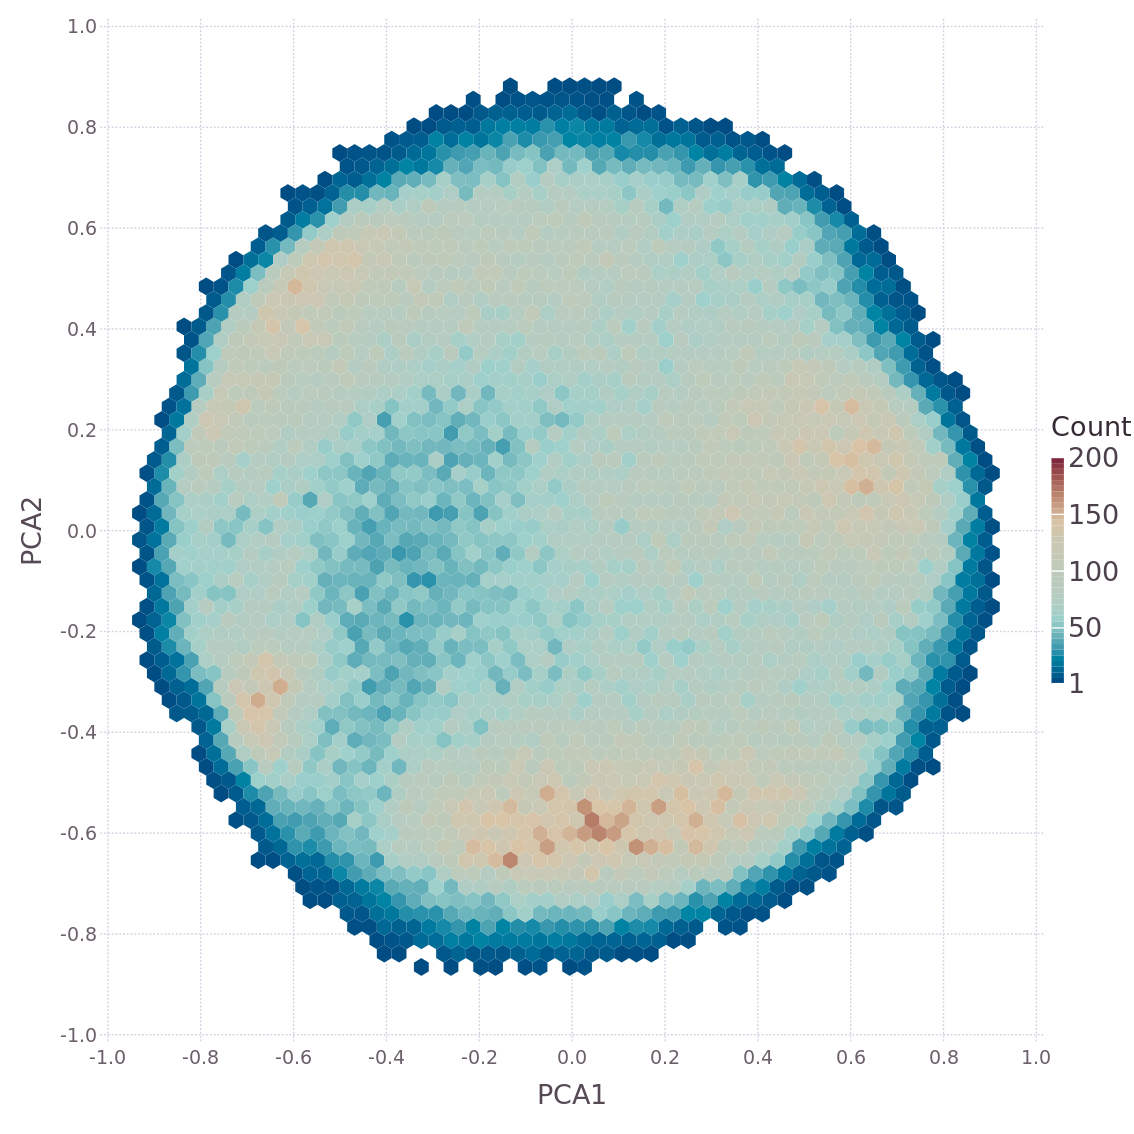

In [50]:
set_default_plot_size(30cm, 30cm)
pdf_prj_4uet = plot(df_prj_4uet, x = "PCA1", y = "PCA2",
    #color = "Time",
    Geom.hexbin(xbincount = 80, ybincount = 80),
    #Geom.smooth(method=:loess,smoothing=0.001),
    #Guide.title("Cut"),

    #Coord.cartesian(xmin = -1., xmax = 1., ymin = -1., ymax = 1.),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), 
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.xticks(ticks=collect(-1:.2:1)),
    Guide.yticks(ticks=collect(-1:.2:1)),
    
    #Scale.color_continuous(colormap=Scale.lab_gradient("#f2f2f2", "Indigo", "DarkMagenta", "Black")),
    #Scale.color_continuous(minvalue = 200),
    #Scale.x_continuous(minvalue = 200),
    #Scale.y_continuous(minvalue = 200),
    
    Theme(bar_spacing=2pt, grid_line_width = 1pt, line_width = 2pt, point_size = 0.75pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 20pt))

In [53]:
set_default_plot_size(30cm, 12cm)

## Separo las poblaciones según PCA

In [43]:
in_bins = collect(-1:.025:1)
his_ind, his = MatHisInd2D(prj_1_4uet, prj_2_4uet, in_bins, in_bins);

In [44]:
msk = his .> 100
main_his = his[msk]
main_his_ind = his_ind[msk];

In [45]:
spy(msk[10:20, 25:35])
spy(msk[30:60, 15:25])
spy(msk[55:71, 45:55])
spy(msk[15:25, 58:65]);

In [51]:
idx_vol0 = collect(Iterators.flatten(his_ind[10:20, 25:35]))
idx_vol1 = collect(Iterators.flatten(his_ind[30:60, 15:25]))
idx_vol2 = collect(Iterators.flatten(his_ind[55:71, 45:55]))
idx_vol3 = collect(Iterators.flatten(his_ind[15:25, 58:65]))

# Estiro el volumen 
full_trj_vol = Array{Float64}(length(trj_vol)*10)
for i = 1:length(trj_vol)
    k = (i-1) * 10 + 1
    full_trj_vol[k:k+9] =  fill(trj_vol[i], 10)
end

trj_vol0 = full_trj_vol[idx_vol0]
trj_vol1 = full_trj_vol[idx_vol1]
trj_vol2 = full_trj_vol[idx_vol2]
trj_vol3 = full_trj_vol[idx_vol3];

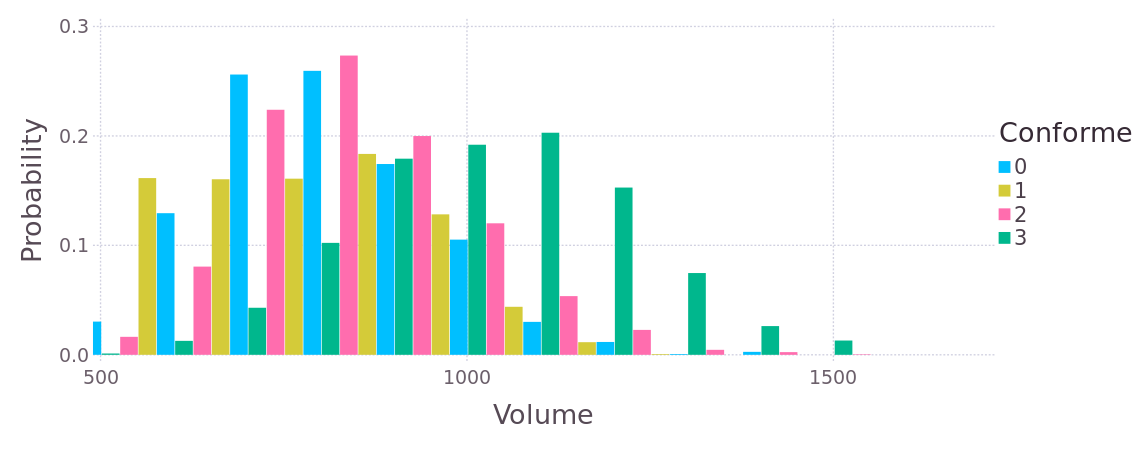

In [64]:
bin_vol = collect(400:100:1600)

# Histograma ponderado
his_vol0, bin_vol0 = WeightedHist(trj_vol0, bin_vol, fill(1.0, length(trj_vol0)), true, false);
his_vol1, bin_vol1 = WeightedHist(trj_vol1, bin_vol, fill(1.0, length(trj_vol1)), true, false);
his_vol2, bin_vol2 = WeightedHist(trj_vol2, bin_vol, fill(1.0, length(trj_vol2)), true, false);
his_vol3, bin_vol3 = WeightedHist(trj_vol3, bin_vol, fill(1.0, length(trj_vol3)), true, false);

df_vol_str = DataFrame(Probability = [ his_vol0 ; his_vol1 ; his_vol2 ; his_vol3 ],
    Volume = [ bin_vol0 ; bin_vol1 ; bin_vol2 ; bin_vol3 ],
    Conformer = [ fill("0", length(bin_vol0)) ; fill("1", length(bin_vol1)) ;
        fill("2", length(bin_vol2)) ; fill("3", length(bin_vol3)) ]);

pdf_Whis_vol_str = plot(df_vol_str, x = "Volume", y = "Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),
    Coord.cartesian(xmin = 500, xmax = 1710),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks = collect(500:100:1700)),

    Theme(bar_spacing=2pt, grid_line_width=1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 16pt))

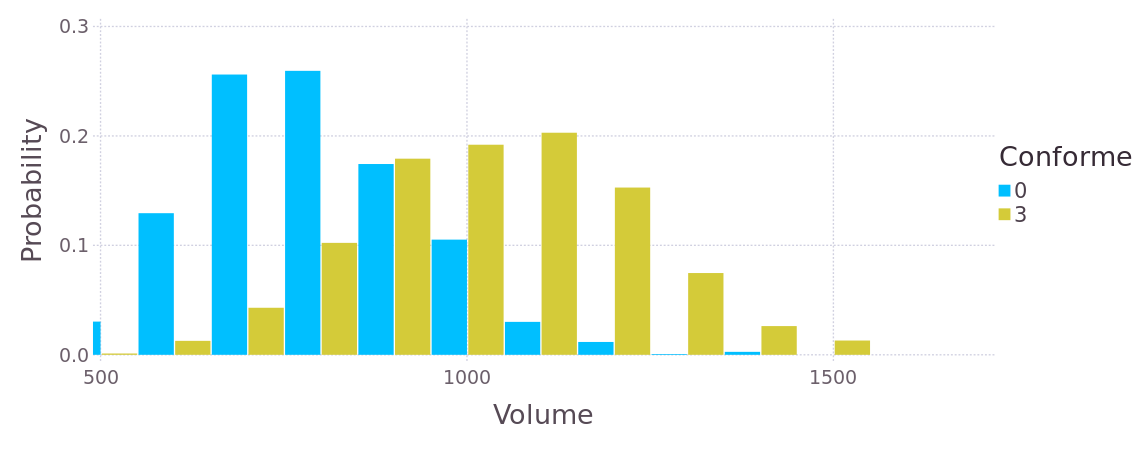

In [65]:
df_vol_str = DataFrame(Probability = [ his_vol0 ; his_vol3 ],
    Volume = [ bin_vol0 ; bin_vol3 ],
    Conformer = [ fill("0", length(bin_vol0)) ; fill("3", length(bin_vol3)) ]);

pdf_Whis_vol_str = plot(df_vol_str, x = "Volume", y = "Probability", color = "Conformer",
    Geom.bar(position = :dodge),
    #Guide.title("Cut"),
    Coord.cartesian(xmin = 500, xmax = 1710),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    #Guide.xticks(ticks = collect(500:100:1700)),

    Theme(bar_spacing=2pt, grid_line_width=1pt,
        minor_label_font_size = 14pt, major_label_font_size = 20pt,
        key_title_font_size = 20pt, key_label_font_size = 16pt))

In [55]:
DataFrame(MEAN = [ mean(trj_vol0) ; mean(trj_vol1) ; mean(trj_vol2) ; mean(trj_vol3) ],
    STD = [ std(trj_vol0) ; std(trj_vol1) ; std(trj_vol2) ; std(trj_vol3) ])

4×2 DataFrames.DataFrame
│ Row │ MEAN    │ STD     │
├─────┼─────────┼─────────┤
│ 1   │ 741.131 │ 147.741 │
│ 2   │ 699.885 │ 194.375 │
│ 3   │ 878.968 │ 151.491 │
│ 4   │ 1083.12 │ 181.23  │

In [38]:
trj_vol_all = [ trj_hivol ; trj_lovol1 ; trj_lovol2 ]

ggg = GMM(2, 1)
ggg.μ[1, 1] = 780. 
ggg.μ[2, 1] = 1250. 
ggg.Σ[1, 1] = 50
ggg.Σ[2, 1] = 150
em!(ggg, reshape(trj_vol_all, length(trj_vol_all), 1), nIter = 30);

In [39]:
lf_prjmal = Normal(ggg.μ[1], sqrt(ggg.Σ[1]))
lf_sampl = rand(lf_prjmal, 1000000)

lb_prjmal = Normal(ggg.μ[2], sqrt(ggg.Σ[2]))
lb_sampl = rand(lb_prjmal, 1000000);

bin_prj = collect(400:10:1700)
wgh_prj = fill(1.0, length(lf_sampl))

# Histograma ponderado
Whis_prj_lf, Wbins_prj_lf = WeightedHist(lf_sampl, bin_prj, wgh_prj, true, false);
df_Whis_prj_lf = DataFrame(Probability = Whis_prj_lf .* 0.35, Volume = Wbins_prj_lf)

# Histograma ponderadotrj_vol_str_all
Whis_prj_lb, Wbins_prj_lb = WeightedHist(lb_sampl, bin_prj, wgh_prj, true, false);
df_Whis_prj_lb = DataFrame(Probability = Whis_prj_lb .* 0.5, Volume = Wbins_prj_lb);

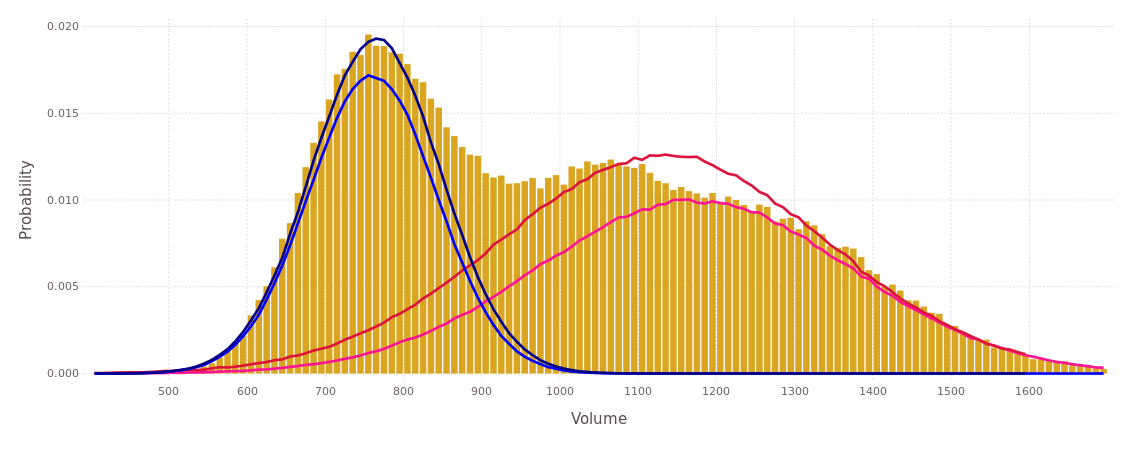

In [40]:
lyr_prj_lf = layer(df_Whis_prj_lf, x = "Volume", y = "Probability",
    Geom.line,
    Theme(default_color=colorant"Blue", line_width = 2pt))
lyr_prj_lb = layer(df_Whis_prj_lb, x = "Volume", y = "Probability",
    Geom.line,
    Theme(default_color=colorant"DeepPink", line_width = 2pt))

lyr_vol_4uet = layer(df_Whis_vol_4uet, x = "Volume", y = "Probability",
    Geom.bar,
    Theme(bar_spacing=1pt, default_color=colorant"GoldenRod"))

pdf_Whis_vol = plot(lyr_nor_lf, lyr_prj_lf, lyr_nor_lb, lyr_prj_lb, lyr_vol_4uet,
    #Guide.title("Cut"),
    #Coord.cartesian(xmin = 300, xmax = 1800, ymax = 0.002),
    #Guide.xlabel("Frecuency (cm<sup>-1</sup>)"), Guide.xticks(ticks=collect(0:50:775)),
    #Guide.ylabel("δV * Probability", orientation=:vertical),
    Guide.xticks(ticks = collect(500:100:1600)))

In [61]:
# Frecuencias
car_vgmodes_4uetmodes_4uetv_4uet = modes_4uet * vgv_4uet
writetable(joinpath(rtdos, "freq_hist_4uet"), df_Whis_evals_4uet, separator = '\t')

# VGV cartesiano
car_vgv_4uet = modes_4uet * vgv_4uet
writedlm(joinpath(rtdos, "car_vgv_4uet"), car_vgv_4uet)

# Volumen
writetable(joinpath(rtdos, "vol_4uet"), df_trj_vol, separator = '\t')

# Histograma de volumen
writetable(joinpath(rtdos, "hist_vol_4uet"), df_Whis_vol_4uet, separator = '\t')

# Energías
writedlm(joinpath(rtdos, "energia_4uet"), E_4uet)